# LA County precinct-level results in the 2020 presidential election

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import json
import requests
import pandas as pd
import altair as alt
import geopandas as gpd
from vega_datasets import data

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = None

In [4]:
place = "precincts"

## Get data

In [5]:
src = (
    pd.read_excel(
        "data/raw/4193_final_svc_excel/PRES_AND_VICE_PRES_11-03-20_by_Precinct_4193-7669.xls",
        skiprows=2,
        names=[
            "location",
            "precinct",
            "series",
            "ballot_group",
            "vbm_only",
            "registration",
            "type",
            "ballots_cast",
            "biden",
            "trump",
            "la_riva",
            "guerra",
            "hawkins",
            "jorgensen",
            "Unnamed: 14",
        ],
    ).drop(["Unnamed: 14"], axis=1)
    # .query("ballots_cast > 0")
    .query('type == "TOTAL"')
).reset_index(drop=True)

#### How many precincts

In [6]:
len(src)

4312

#### Lump the non-major candidates together

In [7]:
other_cols = ["la_riva", "guerra", "hawkins", "jorgensen"]
src["others"] = src[other_cols].sum(axis=1)

#### Define the votes columns and sum the total votes in the presidential race

In [8]:
vote_cols = ["biden", "trump", "others"]
src["total_votes"] = src[vote_cols].sum(axis=1)

#### Create percent columns for each candidates' votes

In [9]:
for v in vote_cols:
    src[f"{v}_pct"] = ((src[f"{v}"] / src["total_votes"]) * 100).round(2)

#### Function to determin the winner in each precinct

In [10]:
def determine_winner(row):
    total_votes = row["biden"] + row["trump"] + row["others"]

    # If there are no votes, return "No votes"
    if total_votes == 0:
        return "No votes"

    # Find the candidate with the maximum number of votes
    max_votes = row[["biden", "trump", "others"]].max()

    # Count the number of candidates with the maximum number of votes
    num_max_votes = sum(row[["biden", "trump", "others"]] == max_votes)

    # If only one candidate has the maximum number of votes, return the winner's name
    if num_max_votes == 1:
        if row["biden"] == max_votes:
            return "Biden"
        elif row["trump"] == max_votes:
            return "Trump"
        else:
            return "Others"
    # If there's a tie, return 'tie'
    else:
        return "Tie"

#### Apply the function to create the 'winner' column

In [11]:
src["winner"] = src.apply(determine_winner, axis=1)

#### Create a clean dataframe with just the columns we need

In [12]:
df = src.drop(
    [
        "series",
        "ballot_group",
        "type",
        "ballots_cast",
        "la_riva",
        "guerra",
        "hawkins",
        "jorgensen",
    ],
    axis=1,
).copy()

#### The resulting dataframe

In [13]:
df.query('precinct.str.startswith("160003")')

,location,precinct,vbm_only,registration,biden,trump,others,total_votes,biden_pct,trump_pct,others_pct,winner
475,CULVER CITY,1600034A,N,2598,1834,317,44,2195,83.55,14.44,2.0,Biden


---

## Geography

#### Precincts list

In [14]:
presidential = list(df.query('vbm_only != "Y"').precinct.unique())

In [15]:
len(presidential)

3438

#### Read precincts [geo file](https://github.com/datadesk/la-county-election-precincts-2020) from the LA Times, via county registrar-recorder

In [16]:
gdf = gpd.read_file("data/raw/la-precincts.json")
gdf.columns = gdf.columns.str.lower()

In [17]:
len(gdf)

3383

#### Limit to presidential precincts with at least one vote and only columns we need

In [18]:
gdf_slim = gdf.query(f"precinct.isin({presidential})").copy()

In [19]:
len(gdf_slim)

2509

---

## Merge

#### Join the results to the geography

In [20]:
merged_df = gpd.GeoDataFrame(pd.merge(df, gdf_slim, on="precinct"))

<Axes: >

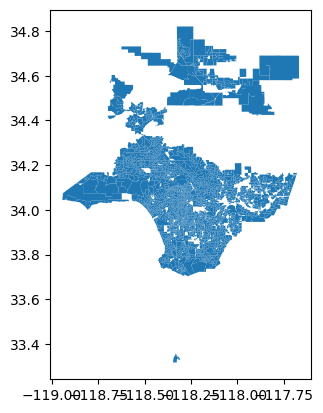

In [21]:
merged_df.plot()

---

## Exports

#### JSON

In [22]:
df.to_json(
    f"data/processed/2020_vote_presidential_precincts.json",
    indent=4,
    orient="records",
)

#### CSV

In [23]:
df.to_csv(f"data/processed/2020_vote_presidential_precincts.csv", index=False)

#### GeoJSON

In [24]:
merged_df.to_file(
    f"data/processed/2020_vote_presidential_precinct_polygons.geojson",
    driver="GeoJSON",
)